## Goals
From an unlabeled video, we want **Random sequences** of frames. 
This will allow us to leverage unlabeled frames for PPCA and temporal penalties together. 
For comparing models, make sure we're using the **same random seed** when initializing `video_pipe`. 
Also, keep some unlabeled videos for training and some for testing.

In [1]:
import os
import numpy as np

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# From tutorial, changing these params for our video
batch_size=2
sequence_length=8
initial_prefetch_size=16
n_iter=6

In [3]:
video_directory = os.path.join('/home/jovyan/mouseRunningData/unlabeled_videos')
assert(os.path.isdir(video_directory))
video_files=[video_directory + '/' + f for f in os.listdir(video_directory)]
print(video_files)

['/home/jovyan/mouseRunningData/unlabeled_videos/180727_001.mp4', '/home/jovyan/mouseRunningData/unlabeled_videos/180726_005.mp4']


In [4]:
@pipeline_def
def video_pipe(filenames):
    videos = fn.readers.video(device="gpu", filenames=filenames, sequence_length=sequence_length,
                              shard_id=0, num_shards=1, random_shuffle=True, initial_fill=initial_prefetch_size)
    return videos

In [5]:
pipe = video_pipe(batch_size=batch_size, num_threads=2, device_id=0, filenames=video_files, seed=123456)
pipe.build()
for i in range(n_iter):
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_cpu().as_array()
    print(sequences_out.shape)

(2, 8, 406, 396, 3)
(2, 8, 406, 396, 3)
(2, 8, 406, 396, 3)
(2, 8, 406, 396, 3)
(2, 8, 406, 396, 3)
(2, 8, 406, 396, 3)


[/opt/dali/dali/operators/reader/nvdecoder/nvdecoder.cc:87] Warning: Decoding on a default stream. Performance may be affected.


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [7]:
def show_sequence(sequence):
    columns = 4
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32,(16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

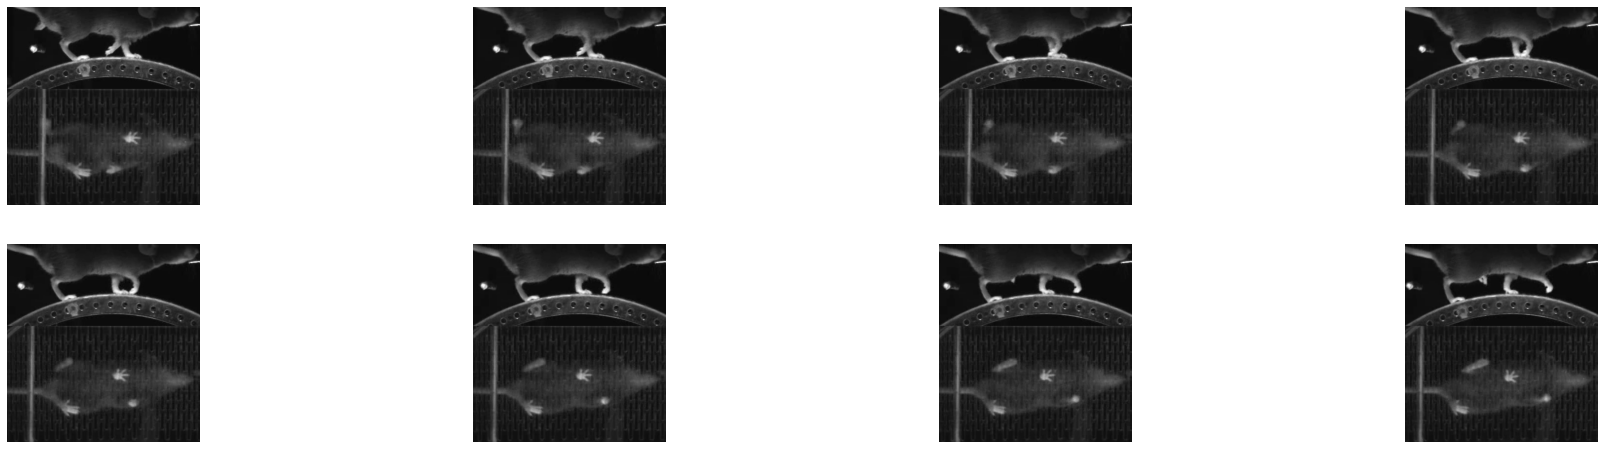

In [8]:
pipe_out = pipe.run()
sequences_out = pipe_out[0].as_cpu().as_array()
show_sequence(sequences_out[0])

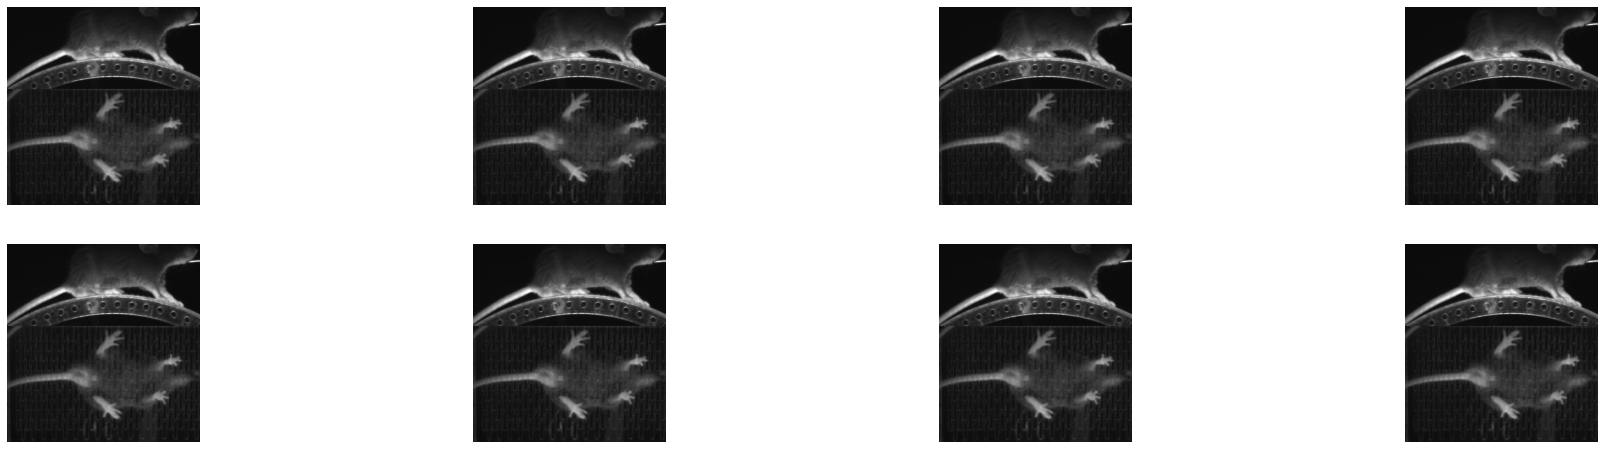

In [9]:
show_sequence(sequences_out[1])

In [10]:
print("min pix val= {}, max pix val = {}".format(np.min(sequences_out), np.max(sequences_out)))

min pix val= 0, max pix val = 255


In [99]:
from pose_est_nets.datasets.datasets import DLCHeatmapDataset, TrackingDataModule

In [100]:
# TODO: mode naming isn't good here and below
# TODO: data transform
# TODO: import iaa
# Hardcoded for fish data for now, in the future we can have feature which will automatically check if a data_transform needs to be applied and select the right transformation
import imgaug.augmenters as iaa
data_transform = []
data_transform.append(
    iaa.Resize({"height": 384, "width": 384})
)  # dlc dimensions need to be repeatably divisable by 2
data_transform = iaa.Sequential(data_transform)
full_data = DLCHeatmapDataset(
        root_directory=os.path.join('/home/jovyan/mouseRunningData'),
        data_path="CollectedData_.csv",
        header_rows=[1, 2],
        mode="csv",
        noNans=True,
        transform=data_transform,
    )

/home/jovyan/pose-estimation-nets/pose_est_nets/datasets/datasets.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(self.labels)

  6%|▌         | 13/227 [00:00<00:01, 124.04it/s]

(396, 406)
(384, 384, 3)
227 227
torch.Size([227, 17, 2])



100%|██████████| 227/227 [00:01<00:00, 118.82it/s]


34


In [101]:
datamod = TrackingDataModule(
        full_data,
        mode="random",
        train_batch_size=16,
        validation_batch_size=10,
        test_batch_size=1,
    use_unlabeled_frames=True,
    )  # dlc configs
data = full_data

datamod.setup()
datamod.setup_unlabeled(video_files)
datamod.computePPCA_params()

datalen:
227
181 23 23
[8.87332091e-01 7.10287777e-02 4.10185198e-02 6.20611938e-04]
0.9993793880617715


In [49]:
out = next(iter(datamod.val_dataloader()))

/home/jovyan/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [50]:
print(len(out))
print(out[0].shape)
print(out[1].shape)

2
torch.Size([10, 3, 384, 384])
torch.Size([10, 17, 96, 96])


In [76]:
# # NO NEED FOR THIS. it's all in the CombinedLoader class below
# #data_loader = datamod.train_dataloader()
# data_loader = [datamod.train_dataloader()[k] for k in datamod.train_dataloader().keys()]
# print(data_loader)
# if isinstance(data_loader, dict):
#     example_batch = {k : next(iter(data_loader[k])) for k in data_loader.keys()}
# elif isinstance(data_loader, torch.utils.data.dataloader.DataLoader):
#     example_batch = next(iter(data_loader))
# elif isinstance(data_loader, list):
#     example_batch = [next(iter(data_loader[k])) for k in len(data_loader)]
# else:
#     print("Handle errors")
#     # Handle errors

[<torch.utils.data.dataloader.DataLoader object at 0x7f560d5c3700>, <torch.utils.data.dataloader.DataLoader object at 0x7f560d675760>]


TypeError: 'int' object is not iterable

In [91]:
from pytorch_lightning.trainer.supporters import CombinedLoader

loader = CombinedLoader(datamod.train_dataloader())
out = next(iter(loader))
print(type(out))
print(out.keys())
out["unlabeled"].shape


<class 'dict'>
dict_keys(['labeled', 'unlabeled'])


/home/jovyan/pose-estimation-nets/pose_est_nets/datasets/datasets.py:364: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


In [93]:
#out = next(iter(datamod.train_dataloader()))

torch.Size([7, 3, 406, 396])

In [64]:
out = next(iter(datamod.train_dataloader()["unlabeled"]))

In [65]:
print(len(out))
print(out[0].shape)
print(out[1].shape)
#next(iter(datamod.semi_supervised_loader)).shape

2
torch.Size([16, 3, 384, 384])
torch.Size([16, 17, 96, 96])


In [102]:
from pose_est_nets.models.heatmap_tracker import Semi_Supervised_DLC

model = Semi_Supervised_DLC(
    num_targets=34, # TODO: this arg is problematic, can be confusing. stick to num_keypoints.
    resnet_version=18,
)

In [103]:
if 'PL_TRAINER_GPUS' in os.environ:
    os.environ.pop('PL_TRAINER_GPUS')

In [104]:
import torch
import pytorch_lightning as pl
model.pca_param_dict = datamod.pca_param_dict
model.output_shape = data.output_shape
model.output_sigma = data.output_sigma
device = "cuda" if torch.cuda.is_available() else "cpu"
model.upsample_factor = torch.tensor(100, device=device) # TODO: clarify this
model.confidence_scale = torch.tensor(255.0, device=device) # TODO: clarify

In [105]:
trainer = pl.Trainer(
    gpus=1,
    log_every_n_steps=1,
    max_epochs=3,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [106]:
trainer.fit(model=model, datamodule = datamod)

/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 11.2 M
1 | upsampling_layers | Sequential | 22.2 K
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.795    Total estimated model params size (MB)


/home/jovyan/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<class 'list'>
2
x.shape in validation_step of child class: torch.Size([10, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([10, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([10, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([10, 17, 96, 96])
<class 'list'>
2
x.shape in validation_step of child class: torch.Size([10, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([10, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([10, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([10, 17, 96, 96])


/home/jovyan/pose-estimation-nets/pose_est_nets/datasets/datasets.py:364: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(
/home/jovyan/conda/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/jovyan/pose-estimation-nets/pose_est_nets/utils/heatmap_tracker_utils.py:140: UserWarning: To copy construct from a tensor, it is recommended to use

<class 'torch.Tensor'>
<class 'torch.Tensor'>
16
16
<class 'torch.Tensor'>
7
representations.shape in forward method of parent class: torch.Size([16, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([16, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([7, 512, 13, 13])
out.shape in forward method of parent class: torch.Size([7, 17, 104, 104])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
16
16
<class 'torch.Tensor'>
7
representations.shape in forward method of parent class: torch.Size([16, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([16, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([7, 512, 13, 13])
out.shape in forward method of parent class: torch.Size([7, 17, 104, 104])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
16
16
<class 'torch.Tensor'>
7
representations.shape in forward method of parent class: torch.Size([16, 512, 12, 12])
out.shape in forward method of parent 

<class 'list'>
2
x.shape in validation_step of child class: torch.Size([10, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([10, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([10, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([10, 17, 96, 96])
<class 'list'>
2
x.shape in validation_step of child class: torch.Size([10, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([10, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([10, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([10, 17, 96, 96])
<class 'list'>
2
x.shape in validation_step of child class: torch.Size([3, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([3, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([3, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([3, 17, 96, 96])
<class 'torch.Tensor'>
<class 'torc

<class 'list'>
2
x.shape in validation_step of child class: torch.Size([10, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([10, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([10, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([10, 17, 96, 96])
<class 'list'>
2
x.shape in validation_step of child class: torch.Size([10, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([10, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([10, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([10, 17, 96, 96])
<class 'list'>
2
x.shape in validation_step of child class: torch.Size([3, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([3, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([3, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([3, 17, 96, 96])
<class 'torch.Tensor'>
<class 'torc

<class 'list'>
2
x.shape in validation_step of child class: torch.Size([10, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([10, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([10, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([10, 17, 96, 96])
<class 'list'>
2
x.shape in validation_step of child class: torch.Size([10, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([10, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([10, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([10, 17, 96, 96])
<class 'list'>
2
x.shape in validation_step of child class: torch.Size([3, 3, 384, 384])
y.shape in validation_step of child class: torch.Size([3, 17, 96, 96])
representations.shape in forward method of parent class: torch.Size([3, 512, 12, 12])
out.shape in forward method of parent class: torch.Size([3, 17, 96, 96])



In [20]:
from pytorch_lightning import LightningModule
import torch 

In [24]:
class LitModel(LightningModule):
    def train_dataloader(self):

        loader_a = torch.utils.data.DataLoader(range(8), batch_size=4)
        loader_b = torch.utils.data.DataLoader(range(16), batch_size=4)
        loader_c = torch.utils.data.DataLoader(range(32), batch_size=4)
        loader_d = torch.utils.data.DataLoader(range(64), batch_size=4)

        # pass loaders as a nested dict. This will create batches like this:
        loaders = {"loaders_a_b": [loader_a, loader_b], "loaders_c_d": {"c": loader_c, "d": loader_d}}
        return loaders

    def training_step(self, batch, batch_idx):
        # access the data
        batch_a_b = batch["loaders_a_b"]
        batch_c_d = batch["loaders_c_d"]

        batch_a = batch_a_b[0]
        batch_b = batch_a_b[1]

        batch_c = batch_c_d["c"]
        batch_d = batch_c_d["d"]

In [25]:
lit_model = LitModel()

In [31]:
lit_model.train_dataloader()

{'loaders_a_b': [<torch.utils.data.dataloader.DataLoader at 0x7f95cc48b640>,
 'loaders_c_d': {'c': <torch.utils.data.dataloader.DataLoader at 0x7f95cc48b100>,
  'd': <torch.utils.data.dataloader.DataLoader at 0x7f95cc46f220>}}

In [32]:

#datamod.train_dataloader()

/home/jovyan/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'labeled': <torch.utils.data.dataloader.DataLoader at 0x7f95cc48b0d0>,
 'unlabeled': <bound method TrackingDataModule.unlabeled_dataloader of <pose_est_nets.datasets.datasets.TrackingDataModule object at 0x7f94e3f66520>>}

In [33]:
nex(iter(datamo))

TypeError: training_step() missing 2 required positional arguments: 'batch' and 'batch_idx'